In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shapely

In [2]:
def discretize(x,y,ds):
    dr = (np.diff(x)**2 + np.diff(y)**2)**.5 # segment lengths
    r = np.zeros_like(x)
    r[1:] = np.cumsum(dr) # integrate path
    r_int = np.linspace(0, r.max(), ds) # regular spaced path
    x_int = np.interp(r_int, r, x) # interpolate
    y_int = np.interp(r_int, r, y)
    return [x_int,y_int]

def write_grid(xf,yf,delft3dgridfile):
    a=xf
    nmax=len(a)
    mmax=len(a[0])
    with open(delft3dgridfile, 'w') as w:
        w.write("*\n")
        w.write("Coordinate System = Cartesian\n")
        w.write("Missing Value     =   -9.99999000000000024E+02\n")
        w.write("{1} {0}\n".format(nmax, mmax))
        w.write("0 0 0\n")
        for ix, rowx in enumerate(a, start=1):
            # Write start
            w.write(f'row=    {ix}    ')
            # Get spaces for row overflow
            space = (12 + len(str(ix)))*' '
            # Split row into sections of 5
            tempa = [rowx[ix:ix+5] for ix in range(0, len(rowx), 5)]
            # Write row and .join sections by newline + spaces
            w.write(
                f'\n{space}'.join(['    '.join([f'{a:.6E}' for a in b]) for b in tempa]))
            w.write('\n')
            a=yf
        for ix, rowx in enumerate(a, start=1):
            # Write start
            w.write(f'row=    {ix}    ')
            # Get spaces for row overflow
            space = (12 + len(str(ix)))*' '
            # Split row into sections of 5
            tempa = [rowx[ix:ix+5] for ix in range(0, len(rowx), 5)]
            # Write row and .join sections by newline + spaces
            w.write(
                f'\n{space}'.join(['    '.join([f'{a:.6E}' for a in b]) for b in tempa]))
            w.write('\n')

def plotGrid(X, Y, chartTitle ='', lineColor='b', lineWidth=1, 
            activatePoint=True, pointColor='r', pointSize=10):
    
    """
    plot: To plot structured grid
        plot(X, Y, lineColor, lineWidth, activatePoint, pointColor, pointSize)
        INPUT:
            X (matrix)      - matrix with x-coordinates of gridpoints
            Y (matrix)      - matrix with y-coordinates of gridpoints
            lineColor       - color of mesh lines. Default blue
            lineWidth       - width of mesh lines.
            activatePoint   - to activate mesh points
            pointColor      - mesh points color
            pointSize       - size of mesh points
    """

    xdiv, ydiv = X.shape    # extracting size, X and Y should be the same

    # Generating plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)

    # point scatter
    if (activatePoint==True):
        ax.scatter(X, Y, c=pointColor, s=pointSize)
    else:
        pass        
    
    # line plot
    for i in range(xdiv):
        ax.plot(X[i,:], Y[i,:], lineColor, lineWidth)
    
    for j in range(ydiv):
        ax.plot(X[:,j], Y[:,j], lineColor, lineWidth)

    ax.minorticks_on()
    ax.grid(visible=True, which='major', color='0.65', linestyle='-')
    ax.grid(visible=True, which='minor', color='0.65', linestyle='--')
    plt.title("2D Structured Grid Generation")
    ax.set(xlim=(0.9999*np.min(xf), (1/0.9999)*np.max(xf)), ylim=(0.9999*np.min(yf), (1/0.9999)*np.max(yf)))
    plt.show()

    # Save figure
    #fName = "results/" + chartTitle + ".png"
   #fig.savefig(fName, dpi=150)

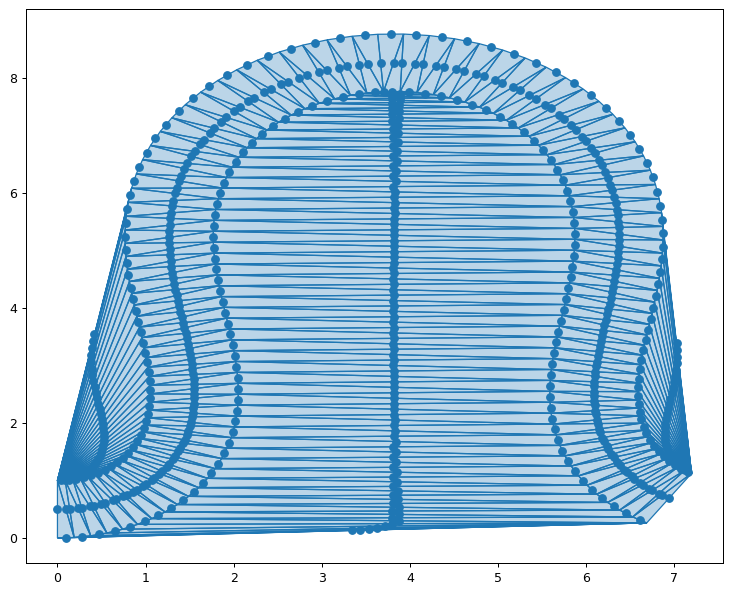

In [9]:
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
from shapely.plotting import plot_polygon, plot_points

combined_x=[*b1_raw_x,*b2_raw_x]
combined_y=[*b1_raw_y,*b2_raw_y]
combined_x_ordered=[*b1_raw_x,*b2_raw_x[::-1]]#orders should be checked
combined_y_ordered=[*b1_raw_y,*b2_raw_y[::-1]]#orders should be checked
poly=shapely.polygons(np.transpose([combined_x_ordered,combined_y_ordered]))
points=MultiPoint(np.transpose([combined_x_ordered,combined_y_ordered]))
triangles = triangulate(points)
tedges=triangulate(points,edges=True)
midpoints=shapely.centroid(tedges)

fig = plt.figure(1, figsize=(10, 8), dpi=90)
ax = fig.add_subplot(111)

for triangle in triangles:
    plot_polygon(triangle, ax=ax, add_points=False)

plot_points(midpoints, ax=ax)

#set_limits(ax, -1, 4, -1, 3)

plt.show()

In [10]:
erosion=poly.buffer(-0.1)
erosion_points=shapely.extract_unique_points(erosion)
#np.array(erosion.exterior)
#shapely.get_point(erosion.exterior)
erosion_boundary=shapely.get_coordinates(erosion_points)

In [11]:
from matplotlib import path
boundarypath = path.Path(erosion_boundary)
#boundarypath = path.Path(np.transpose([combined_x_ordered,combined_y_ordered])) 
midpoints_list=np.transpose([shapely.get_x(midpoints), shapely.get_y(midpoints)])
ids=boundarypath.contains_points(midpoints_list)
centerline=midpoints_list[ids==True]

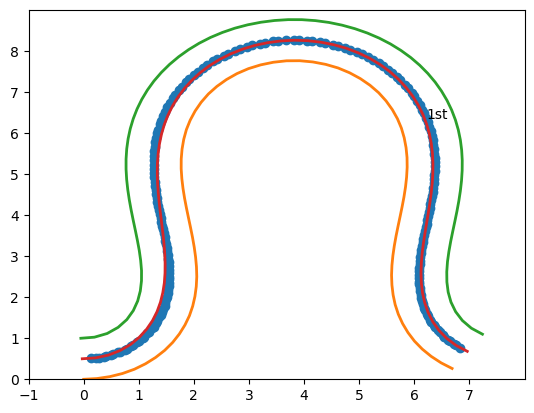

In [12]:
line1 = shapely.LineString(p1)
p1_normal=shapely.line_interpolate_point(line1, np.linspace(0, 1, jmax), normalized=True).tolist()
line2=shapely.offset_curve(line1, 1)
p2_normal=shapely.line_interpolate_point(line2, np.linspace(0, 1, jmax), normalized=True).tolist()


fig, ax = plt.subplots() #figsize=(15, 8)

ax.plot(centerline[:,0], centerline[:,1],'o')
ax.plot(shapely.get_x(p1_normal), shapely.get_y(p1_normal), linewidth=2.0)
ax.plot(shapely.get_x(p2_normal), shapely.get_y(p2_normal) , linewidth=2.0)
ax.plot(0.5*(shapely.get_x(p1_normal)+shapely.get_x(p2_normal)), 0.5*(shapely.get_y(p1_normal)+shapely.get_y(p2_normal)), linewidth=2.0)
ax.annotate("1st",(centerline[0,:]))

ax.set(xlim=(-1, 8), xticks=np.arange(-1, 8),
       ylim=(0, 9), yticks=np.arange(0, 9))

plt.show()

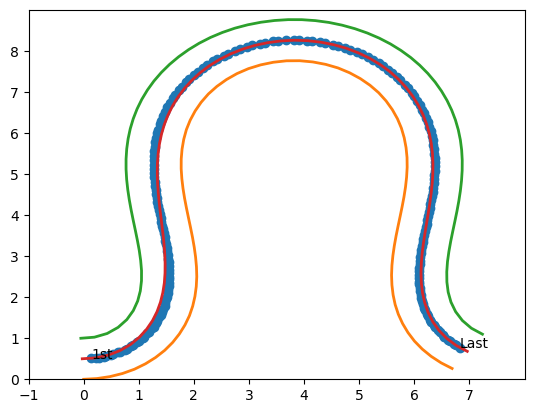

In [14]:
def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    return points_new

ind    = centerline[:,0].argmin()
points_tuples=[(xx,yy)  for xx,yy in zip(centerline[:,0], centerline[:,1])]
#order based on known leftmost location
points_new = order_points(points_tuples, ind)
xn,yn  = np.array(points_new).T

fig, ax = plt.subplots() #figsize=(15, 8)

ax.plot(xn, yn,'o')
ax.plot(shapely.get_x(p1_normal), shapely.get_y(p1_normal), linewidth=2.0)
ax.plot(shapely.get_x(p2_normal), shapely.get_y(p2_normal) , linewidth=2.0)
ax.plot(0.5*(shapely.get_x(p1_normal)+shapely.get_x(p2_normal)), 0.5*(shapely.get_y(p1_normal)+shapely.get_y(p2_normal)), linewidth=2.0)
ax.annotate("1st",((xn[0],yn[0])))
ax.annotate("Last",((xn[-1],yn[-1])))

ax.set(xlim=(-1, 8), xticks=np.arange(-1, 8),
       ylim=(0, 9), yticks=np.arange(0, 9))

plt.show()


# Differential Gird Generation

In [17]:
#print(*X, sep="\n")
#delta_Exi

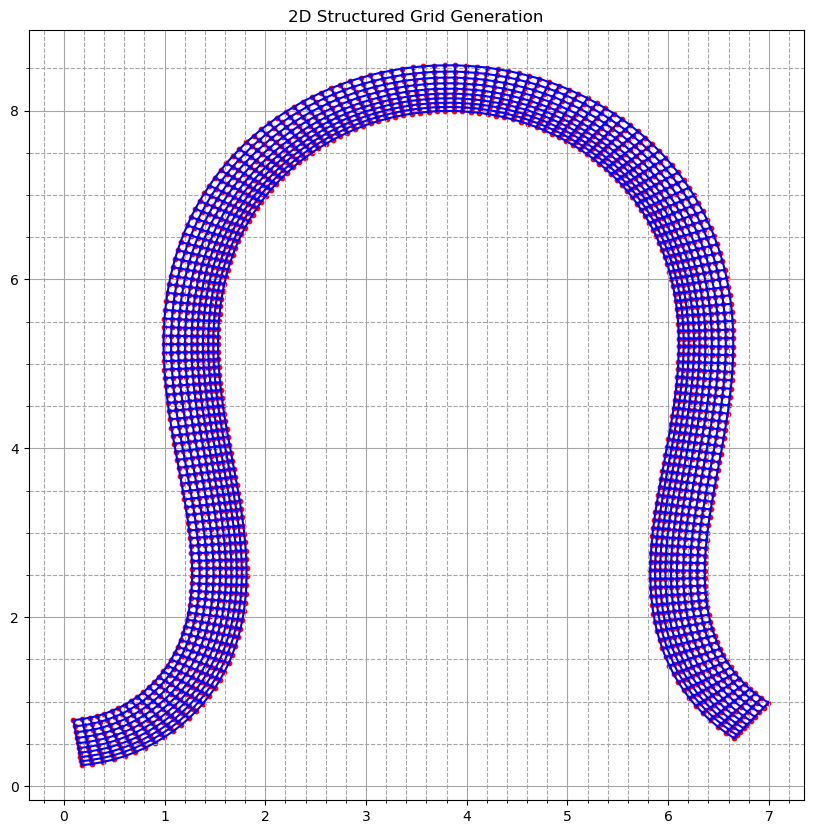

In [96]:
imax=10
jmax=200
#imax=20
#jmax=400
K=0.5
Q=0.05
Xh = np.zeros(shape=(imax,jmax))
Yh = np.zeros(shape=(imax,jmax))
base_line=shapely.line_interpolate_point(C_L, np.linspace(0, 1, jmax), normalized=True).tolist()
Xb=shapely.get_x(base_line)
Yb=shapely.get_y(base_line)
Xh[imax//2,:]=shapely.get_x(base_line)
Yh[imax//2,:]=shapely.get_y(base_line)
delta_Eta=0.1
delta_Exi=shapely.length(C_L)/jmax

for i in range(imax//2+1, imax):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i-1,:]-delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i-1,:]+delta_Eta*V*(dX_dExi)/g11

for i in range(imax//2-1, -1,-1):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i+1,:]+delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i+1,:]-delta_Eta*V*(dX_dExi)/g11
plotGrid(Xh,Yh)

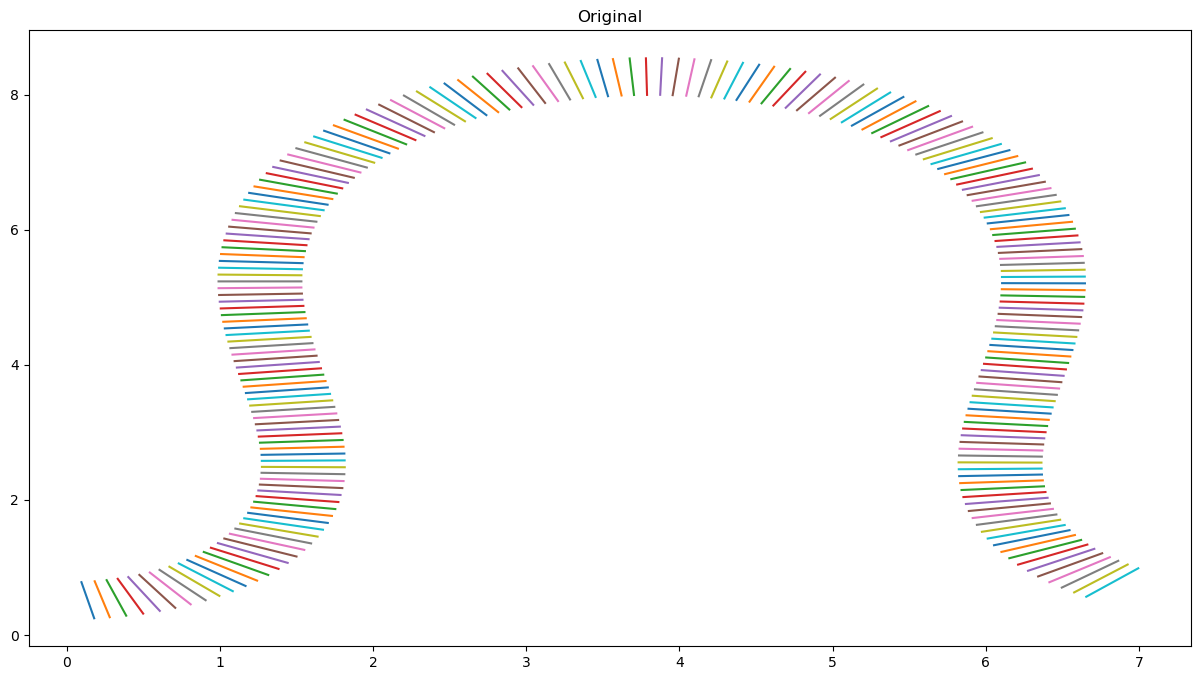

In [97]:
imax=10
jmax=200
#imax=20
#jmax=400
K=0.5
Q=0.05
Xh = np.zeros(shape=(imax,jmax))
Yh = np.zeros(shape=(imax,jmax))
base_line=shapely.line_interpolate_point(C_L, np.linspace(0, 1, jmax), normalized=True).tolist()
Xb=shapely.get_x(base_line)
Yb=shapely.get_y(base_line)
Xh[imax//2,:]=shapely.get_x(base_line)
Yh[imax//2,:]=shapely.get_y(base_line)
delta_Eta=0.1
delta_Exi=shapely.length(C_L)/jmax

for i in range(imax//2+1, imax):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i-1,:]-delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i-1,:]+delta_Eta*V*(dX_dExi)/g11

for i in range(imax//2-1, -1,-1):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i+1,:]+delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i+1,:]-delta_Eta*V*(dX_dExi)/g11

fig = plt.figure(figsize=(15, 8))
plt.subplot()
plt.plot(Xh, Yh, '-')
plt.title('Original')

plt.show()

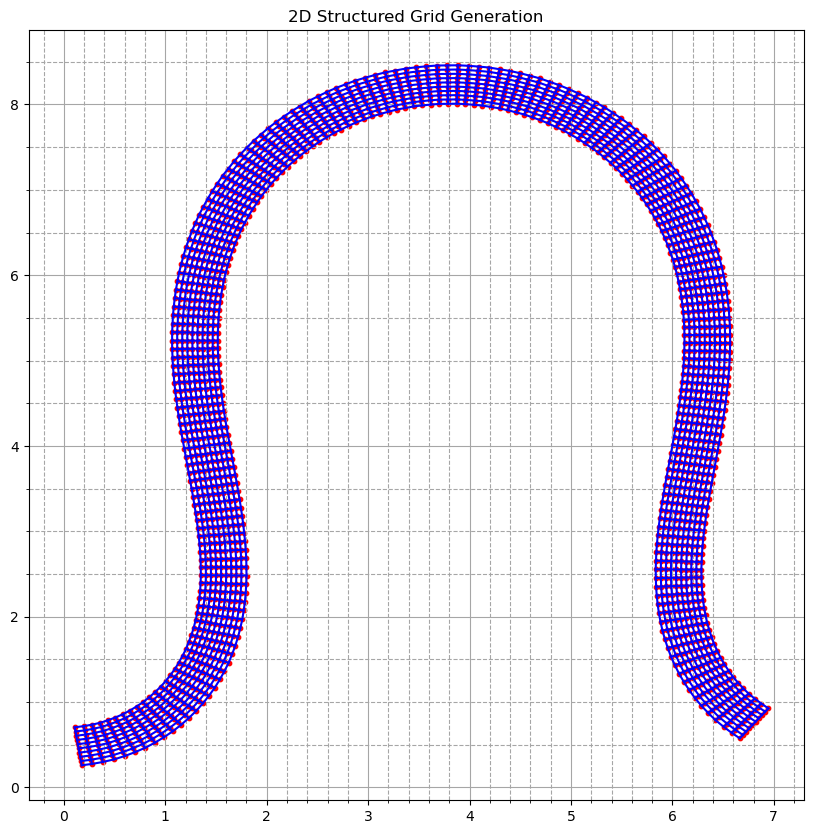

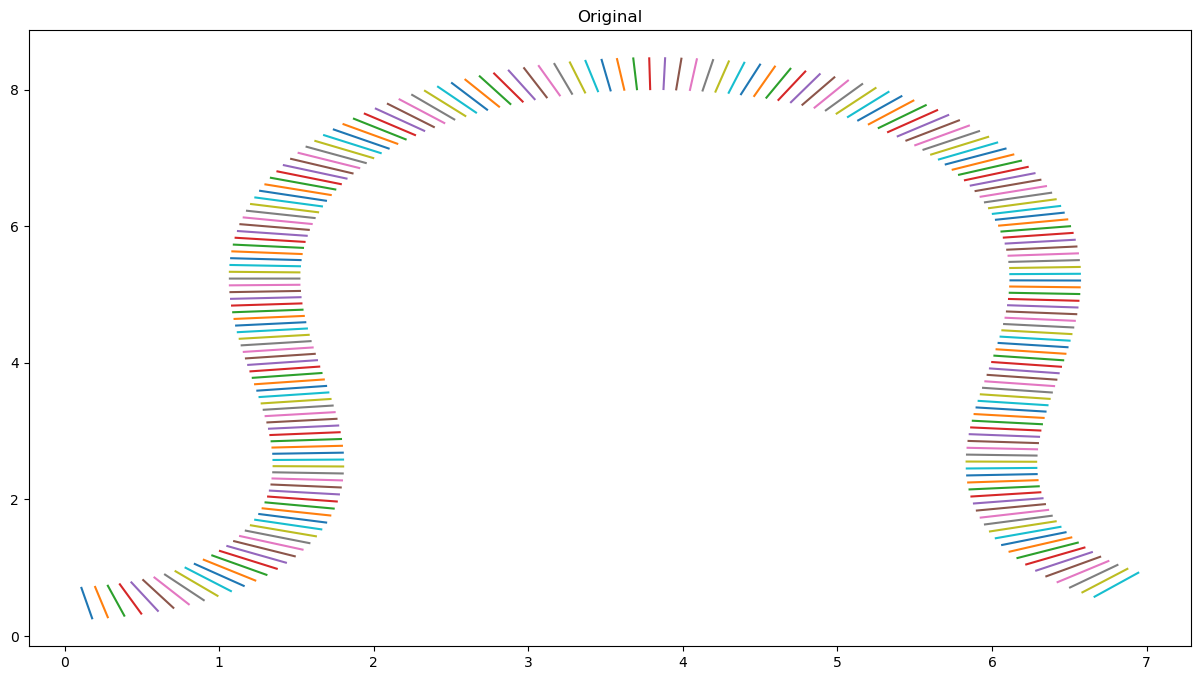

In [101]:
imax=10
jmax=200
#imax=20
#jmax=400
K=1
Q=0
Xh = np.zeros(shape=(imax,jmax))
Yh = np.zeros(shape=(imax,jmax))
base_line=shapely.line_interpolate_point(C_L, np.linspace(0, 1, jmax), normalized=True).tolist()
Xb=shapely.get_x(base_line)
Yb=shapely.get_y(base_line)
Xh[imax//2,:]=shapely.get_x(base_line)
Yh[imax//2,:]=shapely.get_y(base_line)
delta_Eta=0.05
delta_Exi=shapely.length(C_L)/jmax

for i in range(imax//2+1, imax):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i-1,:]-delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i-1,:]+delta_Eta*V*(dX_dExi)/g11

for i in range(imax//2-1, -1,-1):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

    Xh[i,:]=Xh[i+1,:]+delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i+1,:]-delta_Eta*V*(dX_dExi)/g11
plotGrid(Xh,Yh)
    
fig = plt.figure(figsize=(15, 8))
plt.subplot()
plt.plot(Xh, Yh, '-')
plt.title('Original')

plt.show()

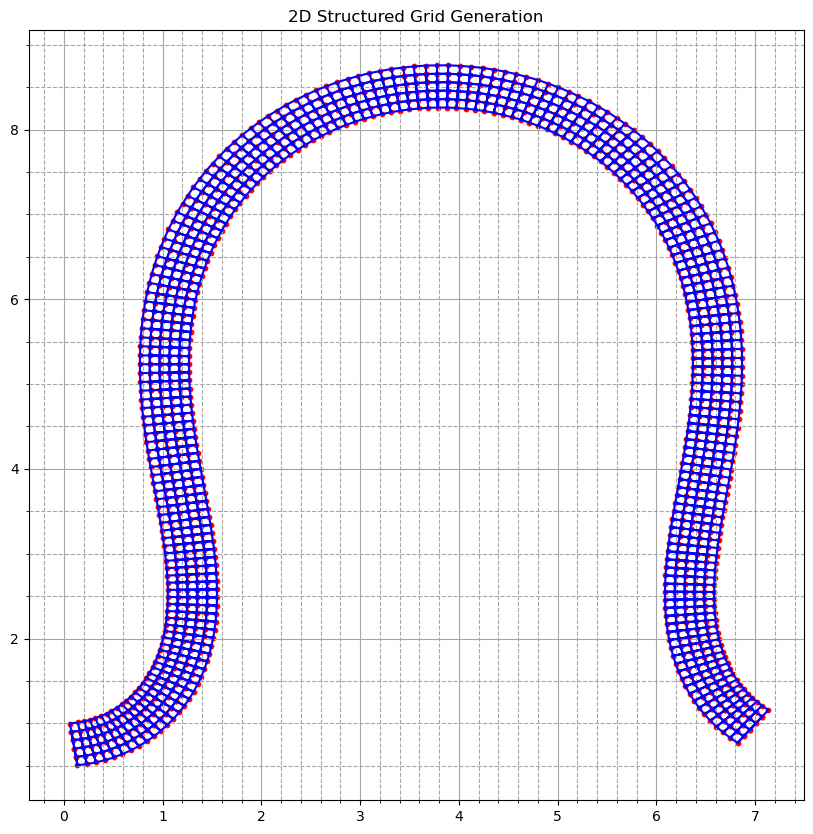

In [102]:
Xh = np.zeros(shape=(imax,jmax))
Yh = np.zeros(shape=(imax,jmax))
base_line=shapely.line_interpolate_point(C_L, np.linspace(0, 1, jmax), normalized=True).tolist()
Xb=shapely.get_x(base_line)
Yb=shapely.get_y(base_line)
Xh[imax//2,:]=shapely.get_x(base_line)
Yh[imax//2,:]=shapely.get_y(base_line)
delta_Eta=0.1
delta_Exi=shapely.length(C_L)/jmax

for i in range(imax//2+1, imax):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=1

    Xh[i,:]=Xh[i-1,:]-delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i-1,:]+delta_Eta*V*(dX_dExi)/g11

for i in range(imax//2-1, -1,-1):

    dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
    dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

    g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
    V=1

    Xh[i,:]=Xh[i+1,:]-delta_Eta*V*(dY_dExi)/g11
    Yh[i,:]=Yh[i+1,:]+delta_Eta*V*(dX_dExi)/g11
plotGrid(Xh,Yh)

In [23]:
import shapely
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
from shapely.plotting import plot_polygon, plot_points
import numpy as np

  
def grid(centerline_x,centerline_y,imax,jmax,delta_Eta):
    p1=shapely.points(centerline_x,centerline_y)
    C_L = shapely.LineString(p1)
    K=1
    Q=0
    Xh = np.zeros(shape=(imax,jmax))
    Yh = np.zeros(shape=(imax,jmax))
    base_line=shapely.line_interpolate_point(C_L, np.linspace(0, 1, jmax), normalized=True).tolist()
    Xb=shapely.get_x(base_line)
    Yb=shapely.get_y(base_line)
    Xh[imax//2,:]=shapely.get_x(base_line)
    Yh[imax//2,:]=shapely.get_y(base_line)
    delta_Exi=shapely.length(C_L)/jmax
    for i in range(imax//2+1, imax):

        dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
        dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

        g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
        V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

        Xh[i,:]=Xh[i-1,:]-delta_Eta*V*(dY_dExi)/g11
        Yh[i,:]=Yh[i-1,:]+delta_Eta*V*(dX_dExi)/g11

    for i in range(imax//2-1, -1,-1):

        dX_dExi=np.concatenate([[Xb[1]-Xb[0]],0.5*(Xb[2:] - Xb[:-2]),[Xb[-1]-Xb[-2]]])/delta_Exi
        dY_dExi=np.concatenate([[Yb[1]-Yb[0]],0.5*(Yb[2:] - Yb[:-2]),[Yb[-1]-Yb[-2]]])/delta_Exi

        g11=np.power(dX_dExi,2)+np.power(dY_dExi,2)
        V=K*np.exp(-Q*(1-i))*np.power(g11,0.5)

        Xh[i,:]=Xh[i+1,:]+delta_Eta*V*(dY_dExi)/g11
        Yh[i,:]=Yh[i+1,:]-delta_Eta*V*(dX_dExi)/g11
    return [Xh,Yh]

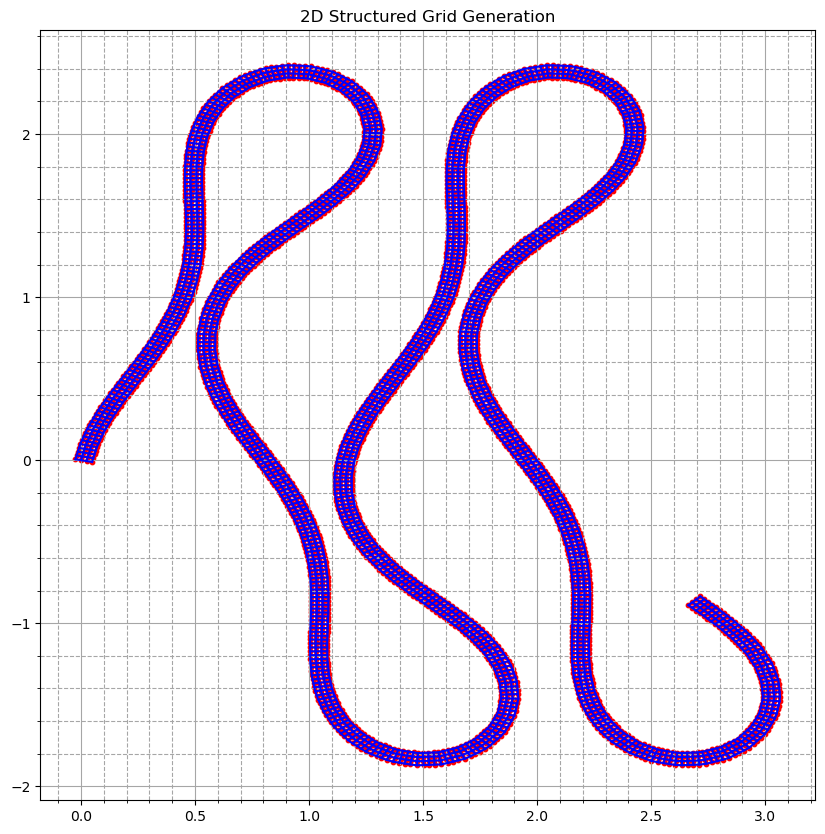

In [33]:
boundary_curve3=np.loadtxt('curve3.txt')
b1_x=boundary_curve3.transpose()[0,:]
b1_y=boundary_curve3.transpose()[1,:]

[xf,yf]=grid(b1_x,b1_y,4,800,0.025)
plotGrid(xf,yf)